In [1]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA","NVDA","AAPL","AMD","F","SOS","RGS"] 

In [4]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  20 of 20 completed


,AAPL,ACN,AMD,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,NVDA,PFE,RGS,SOS,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,
2023-05-16,172.070007,279.190002,101.480003,113.400002,496.149994,90.980003,11.25,78.320000,134.320007,63.220001,28.540001,380.239990,311.059998,292.130005,37.009998,1.04,3.92,166.520004,479.720001,102.519997
2023-05-17,172.690002,284.630005,103.750000,115.500000,495.000000,92.769997,11.50,78.809998,138.449997,63.150002,29.879999,387.000000,314.000000,301.779999,36.750000,1.04,3.93,173.860001,484.809998,104.820000
2023-05-18,175.050003,287.480011,107.930000,118.150002,498.100006,93.760002,11.64,78.209999,139.500000,62.799999,29.959999,392.019989,318.519989,316.779999,36.480000,1.02,4.00,176.889999,479.230011,105.769997
2023-05-19,175.160004,289.910004,105.820000,116.250000,496.519989,91.349998,11.65,78.849998,139.179993,62.830002,29.480000,385.570007,318.339996,312.640015,36.770000,1.01,3.89,180.139999,478.820007,106.260002
2023-05-22,174.199997,290.950012,108.000000,115.010002,491.869995,91.820000,11.63,78.620003,138.029999,61.509998,29.320000,384.529999,321.179993,311.760010,38.750000,1.02,4.02,188.869995,480.619995,104.970001


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.122347
1993-02-01    25.301016
1993-02-02    25.354618
1993-02-03    25.622652
1993-02-04    25.729853
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 2388130529280,
 'AMZN': 1180048687104,
 'KO': 266004905984,
 'MA': 364391759872,
 'COST': 218135986176,
 'LUV': 17447540736,
 'XOM': 424391639040,
 'PFE': 218755760128,
 'JPM': 403363659776,
 'UNH': 447472599040,
 'ACN': 183892049920,
 'DIS': 167782678528,
 'GILD': 98066661376,
 'F': 46528954368,
 'TSLA': 598623453184,
 'NVDA': 771023044608,
 'AAPL': 2739939573760,
 'AMD': 173918879744,
 'SOS': 25847354,
 'RGS': 46476604}

## Constructing the prior

In [7]:
import pypfopt
pypfopt.__version__

'1.5.4'

In [8]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5446676255257508

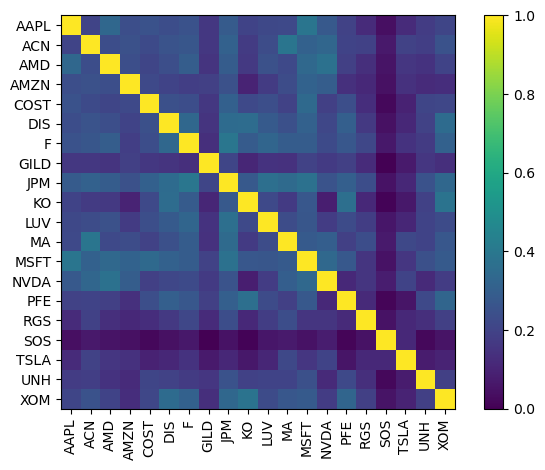

In [9]:
plotting.plot_covariance(S, plot_correlation=True);

In [10]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.166818
ACN     0.057427
AMD     0.142211
AMZN    0.120801
COST    0.071186
DIS     0.085415
F       0.085796
GILD    0.068074
JPM     0.095290
KO      0.058749
LUV     0.075075
MA      0.057659
MSFT    0.116185
NVDA    0.121548
PFE     0.063841
RGS     0.062297
SOS     0.037549
TSLA    0.057381
UNH     0.073805
XOM     0.064365
dtype: float64

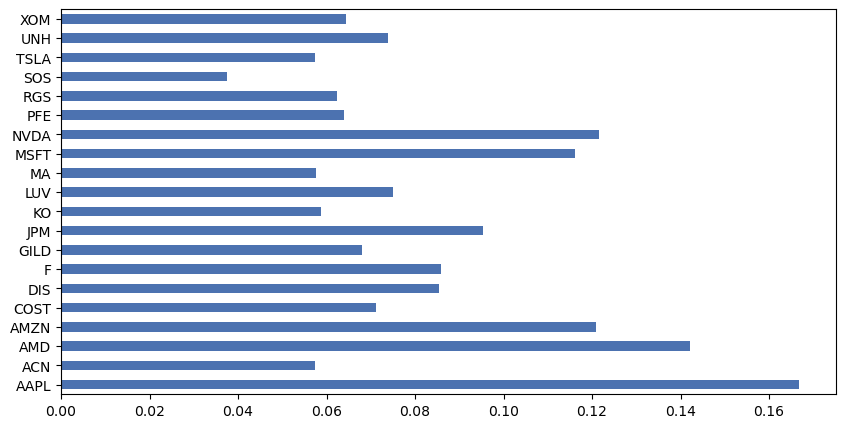

In [11]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [12]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

ValueError: Providing a view on an asset not in the universe

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [13]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [14]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

ValueError: Providing a view on an asset not in the universe

NameError: name 'bl' is not defined

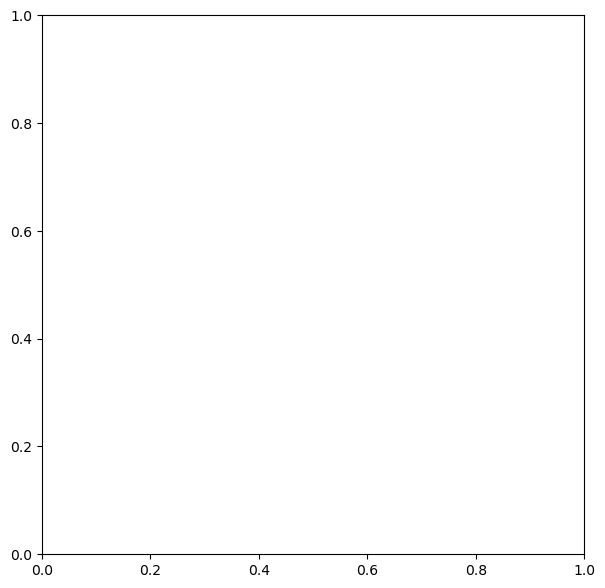

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [16]:
np.diag(bl.omega)

NameError: name 'bl' is not defined

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [17]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [18]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [19]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

ValueError: Providing a view on an asset not in the universe

In [20]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

NameError: name 'bl' is not defined

We can visualise how this compares to the prior and our views:

In [21]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

NameError: name 'ret_bl' is not defined

In [22]:
rets_df.plot.bar(figsize=(12,8));

NameError: name 'rets_df' is not defined

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

In [23]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

NameError: name 'bl' is not defined

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [24]:
from pypfopt import EfficientFrontier, objective_functions

In [25]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

NameError: name 'ret_bl' is not defined

In [26]:
pd.Series(weights).plot.pie(figsize=(10,10));

NameError: name 'weights' is not defined

In [27]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

NameError: name 'weights' is not defined